# Ensemble NMS - Detectron2 [Inference]

### Hi kagglers, This is `Ensemble NMS - Detectron2 [Inference]` notebook.
* [Sartorius Segmentation - Detectron2 [training]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-detectron2-training) 
* [Sartorius Segmentation - Detectron2 [Inference]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-detectron2-inference) 
* [K-fold CrossValidation COCO Dataset Generator](https://www.kaggle.com/ammarnassanalhajali/k-fold-crossvalidation-coco-dataset-generator) 


### Please if this kernel is useful, <font color='red'>please upvote !!</font>

## Other notebooks in this competition 
- [Sartorius Segmentation - Keras U-Net[Training]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-keras-u-net-training)
- [Sartorius Segmentation - Keras U-Net[Inference]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-keras-u-net-inference/edit)

# Intro
Ensembling multiple weaker performing models can help to get the results that you want.

## Install and import libraries

In [1]:
# !pip install ../input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/detectron-05/whls &>/dev/null
# !pip install ../input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/detectron-05/whls &>/dev/null 
# !pip install ../input/detectron-05/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ../input/detectron-05/whls &>/dev/null 
# !pip install ../input/detectron-05/whls/detectron2-0.5/detectron2 --no-index --find-links ../input/detectron-05/whls &>/dev/null 
# !pip install ../input/ensemble-boxes-104/ensemble_boxes-1.0.4/ -f ./ --no-index  &>/dev/null

In [1]:
import os
import cv2
import json
import time
import numpy as np
import pandas as pd
import torch
import detectron2
from tqdm.auto import tqdm
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import inference_on_dataset
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.data import DatasetCatalog, build_detection_test_loader
import pycocotools.mask as mask_util
from PIL import Image
import matplotlib.pyplot as plt
from fastcore.all import *
from ensemble_boxes import nms
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('GPU is available')
else:
    DEVICE = torch.device('cpu')
    print('CPU is used')
print('detectron ver:', detectron2.__version__)

GPU is available
detectron ver: 0.6


## My Models

In [2]:
best_model=( {'file': 'model_best_fold_1.pth','config_name':'Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml', 'LB score': 0.307, 'ths':[0.5, 0.65, 0.5], 'pxls': [70, 75, 70]},
             {'file': 'model_best_fold_2.pth','config_name':'Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml', 'LB score': 0.315, 'ths':[0.5, 0.575, 0.5], 'pxls': [60, 60, 130]},
             {'file': 'model_best_fold_3.pth','config_name':'Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml', 'LB score': 0.297, 'ths':[0.5, 0.6, 0.5], 'pxls': [50, 60, 50]},
             {'file': 'model_best_fold_4.pth','config_name':'Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml', 'LB score': 0.295, 'ths':[0.5, 0.6, 0.5], 'pxls': [50, 50, 60]})

In [3]:
#config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
mdl_path = "output"
DATA_PATH = "sartorius-cell-instance-segmentation"
MODELS = []
BEST_MODELS =[]
THSS = []
PXLS = []
ID_TEST = 0
SUBM_PATH = f'{DATA_PATH}/test'
SINGLE_MODE = False
NMS = False
WBF = True
MIN_PIXELS = [60, 60, 60]
IOU_TH = .4
for b_m in best_model:
    model_name=b_m["file"]
    model_ths=b_m["ths"]
    model_pxls=b_m["pxls"]
    config_name=b_m["config_name"]
    BEST_MODELS.append(model_name)
    THSS.append(model_ths)
    PXLS.append(model_pxls)
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_name))
    cfg.INPUT.MASK_FORMAT = 'bitmask'
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
    cfg.MODEL.WEIGHTS = f'{mdl_path}/{model_name}'  
    cfg.TEST.DETECTIONS_PER_IMAGE = 1000
    MODELS.append(DefaultPredictor(cfg))
print(f'all loaded:\nthresholds: {THSS}\nmodels: {BEST_MODELS}')

all loaded:
thresholds: [[0.5, 0.65, 0.5], [0.5, 0.575, 0.5], [0.5, 0.6, 0.5], [0.5, 0.6, 0.5]]
models: ['model_best_fold_1.pth', 'model_best_fold_2.pth', 'model_best_fold_3.pth', 'model_best_fold_4.pth']


In [5]:
MODELS

## Utils

In [107]:
import warnings
from numba import jit

@jit(nopython=True)
def bb_intersection_over_union(A, B) -> float:
    xA = max(A[0], B[0])
    yA = max(A[1], B[1])
    xB = min(A[2], B[2])
    yB = min(A[3], B[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    if interArea == 0:
        return 0.0

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (A[2] - A[0]) * (A[3] - A[1])
    boxBArea = (B[2] - B[0]) * (B[3] - B[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


def prefilter_boxes(boxes, scores, labels, weights, thr):
    # Create dict with boxes stored by its label
    new_boxes = dict()

    for t in range(len(boxes)):

        if len(boxes[t]) != len(scores[t]):
            print('Error. Length of boxes arrays not equal to length of scores array: {} != {}'.format(len(boxes[t]), len(scores[t])))
            exit()

        if len(boxes[t]) != len(labels[t]):
            print('Error. Length of boxes arrays not equal to length of labels array: {} != {}'.format(len(boxes[t]), len(labels[t])))
            exit()

        for j in range(len(boxes[t])):
            score = scores[t][j]
            if score < thr:
                continue
            label = int(labels[t][j])
            box_part = boxes[t][j]
            x1 = float(box_part[0])
            y1 = float(box_part[1])
            x2 = float(box_part[2])
            y2 = float(box_part[3])

            # Box data checks
            if x2 < x1:
                warnings.warn('X2 < X1 value in box. Swap them.')
                x1, x2 = x2, x1
            if y2 < y1:
                warnings.warn('Y2 < Y1 value in box. Swap them.')
                y1, y2 = y2, y1
            if x1 < 0:
                warnings.warn('X1 < 0 in box. Set it to 0.')
                x1 = 0
            if x1 > 1:
                warnings.warn('X1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                x1 = 1
            if x2 < 0:
                warnings.warn('X2 < 0 in box. Set it to 0.')
                x2 = 0
            if x2 > 1:
                warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                x2 = 1
            if y1 < 0:
                warnings.warn('Y1 < 0 in box. Set it to 0.')
                y1 = 0
            if y1 > 1:
                warnings.warn('Y1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                y1 = 1
            if y2 < 0:
                warnings.warn('Y2 < 0 in box. Set it to 0.')
                y2 = 0
            if y2 > 1:
                warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                y2 = 1
            if (x2 - x1) * (y2 - y1) == 0.0:
                warnings.warn("Zero area box skipped: {}.".format(box_part))
                continue

            # [label, score, weight, model index, x1, y1, x2, y2]
            b = [int(label), float(score) * weights[t], weights[t], t, x1, y1, x2, y2, j]
            if label not in new_boxes:
                new_boxes[label] = []
            new_boxes[label].append(b)

    # Sort each list in dict by score and transform it to numpy array
    for k in new_boxes:
        current_boxes = np.array(new_boxes[k])
        new_boxes[k] = current_boxes[current_boxes[:, 1].argsort()[::-1]]

    return new_boxes


def get_weighted_box(boxes, conf_type='avg'):
    """
    Create weighted box for set of boxes
    :param boxes: set of boxes to fuse
    :param conf_type: type of confidence one of 'avg' or 'max'
    :return: weighted box (label, score, weight, x1, y1, x2, y2)
    """
    box = np.zeros(8, dtype=np.float32)
    conf = 0
    conf_list = []
    w = 0
    for b in boxes:
        box[4:8] += (b[1] * b[4:8])
        conf += b[1]
        conf_list.append(b[1])
        w += b[2]
    box[0] = boxes[0][0]
    if conf_type == 'avg':
        box[1] = conf / len(boxes)
    elif conf_type == 'max':
        box[1] = np.array(conf_list).max()
    elif conf_type in ['box_and_model_avg', 'absent_model_aware_avg']:
        box[1] = conf / len(boxes)
    box[2] = w
    box[3] = -1 # model index field is retained for consistensy but is not used.
    box[4:8] /= conf
    return box


def find_matching_box(boxes_list, new_box, match_iou):
    best_iou = match_iou
    best_index = -1
    for i in range(len(boxes_list)):
        box = boxes_list[i]
        if box[0] != new_box[0]:
            continue
        iou = bb_intersection_over_union(box[4:8], new_box[4:8])
        if iou > best_iou:
            best_index = i
            best_iou = iou

    return best_index, best_iou


def find_matching_box_quickly(boxes_list, new_box, match_iou):
    """ Reimplementation of find_matching_box with numpy instead of loops. Gives significant speed up for larger arrays
        (~100x). This was previously the bottleneck since the function is called for every entry in the array.
    """
    def bb_iou_array(boxes, new_box):
        # bb interesection over union
        xA = np.maximum(boxes[:, 0], new_box[0])
        yA = np.maximum(boxes[:, 1], new_box[1])
        xB = np.minimum(boxes[:, 2], new_box[2])
        yB = np.minimum(boxes[:, 3], new_box[3])

        interArea = np.maximum(xB - xA, 0) * np.maximum(yB - yA, 0)

        # compute the area of both the prediction and ground-truth rectangles
        boxAArea = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        boxBArea = (new_box[2] - new_box[0]) * (new_box[3] - new_box[1])

        iou = interArea / (boxAArea + boxBArea - interArea)

        return iou

    if boxes_list.shape[0] == 0:
        return -1, match_iou

    # boxes = np.array(boxes_list)
    boxes = boxes_list

    ious = bb_iou_array(boxes[:, 4:8], new_box[4:8])

    ious[boxes[:, 0] != new_box[0]] = -1

    best_idx = np.argmax(ious)
    best_iou = ious[best_idx]

    if best_iou <= match_iou:
        best_iou = match_iou
        best_idx = -1

    return best_idx, best_iou


def weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=None, iou_thr=0.55, skip_box_thr=0.0, conf_type='avg', allows_overflow=False):
    '''
    :param boxes_list: list of boxes predictions from each model, each box is 4 numbers.
    It has 3 dimensions (models_number, model_preds, 4)
    Order of boxes: x1, y1, x2, y2. We expect float normalized coordinates [0; 1]
    :param scores_list: list of scores for each model
    :param labels_list: list of labels for each model
    :param weights: list of weights for each model. Default: None, which means weight == 1 for each model
    :param iou_thr: IoU value for boxes to be a match
    :param skip_box_thr: exclude boxes with score lower than this variable
    :param conf_type: how to calculate confidence in weighted boxes. 'avg': average value, 'max': maximum value, 'box_and_model_avg': box and model wise hybrid weighted average, 'absent_model_aware_avg': weighted average that takes into account the absent model.
    :param allows_overflow: false if we want confidence score not exceed 1.0

    :return: boxes: boxes coordinates (Order of boxes: x1, y1, x2, y2).
    :return: scores: confidence scores
    :return: labels: boxes labels
    '''
    if weights is None:
        weights = np.ones(len(boxes_list))
    if len(weights) != len(boxes_list):
        print('Warning: incorrect number of weights {}. Must be: {}. Set weights equal to 1.'.format(len(weights), len(boxes_list)))
        weights = np.ones(len(boxes_list))
    weights = np.array(weights)

    if conf_type not in ['avg', 'max', 'box_and_model_avg', 'absent_model_aware_avg']:
        print('Unknown conf_type: {}. Must be "avg", "max" or "box_and_model_avg", or "absent_model_aware_avg"'.format(conf_type))
        exit()

    filtered_boxes = prefilter_boxes(boxes_list, scores_list, labels_list, weights, skip_box_thr)
    if len(filtered_boxes) == 0:
        return np.zeros((0, 4)), np.zeros((0,)), np.zeros((0,)), np.zeros((0,))

    overall_boxes = []
    overall_indexes = []
    for label in filtered_boxes:
        boxes = filtered_boxes[label]
        new_boxes = []
        new_indexes = []
        weighted_boxes = np.empty((0,8))
        # Clusterize boxes
        for j in range(0, len(boxes)):
            index, best_iou = find_matching_box_quickly(weighted_boxes, boxes[j], iou_thr)
            prev_index = int(boxes[j][8])
            if index != -1:
                new_boxes[index].append(boxes[j][:8])
                new_indexes[index].append(prev_index)
                weighted_boxes[index] = get_weighted_box(new_boxes[index], conf_type)
            else:
                new_boxes.append([boxes[j][:8].copy()])
                new_indexes.append([prev_index])
                weighted_boxes = np.vstack((weighted_boxes, boxes[j][:8].copy()))
        # Rescale confidence based on number of models and boxes
        for i in range(len(new_boxes)):
            clustered_boxes = np.array(new_boxes[i])
            if conf_type == 'box_and_model_avg':
                # weighted average for boxes
                weighted_boxes[i, 1] = weighted_boxes[i, 1] * len(clustered_boxes) / weighted_boxes[i, 2]
                # identify unique model index by model index column
                _, idx = np.unique(clustered_boxes[:, 3], return_index=True)
                # rescale by unique model weights
                weighted_boxes[i, 1] = weighted_boxes[i, 1] *  clustered_boxes[idx, 2].sum() / weights.sum()
            elif conf_type == 'absent_model_aware_avg':
                # get unique model index in the cluster
                models = np.unique(clustered_boxes[:, 3]).astype(int)
                # create a mask to get unused model weights
                mask = np.ones(len(weights), dtype=bool)
                mask[models] = False
                # absent model aware weighted average
                weighted_boxes[i, 1] = weighted_boxes[i, 1] * len(clustered_boxes) / (weighted_boxes[i, 2] + weights[mask].sum())
            elif conf_type == 'max':
                weighted_boxes[i, 1] = weighted_boxes[i, 1] / weights.max()
            elif not allows_overflow:
                weighted_boxes[i, 1] = weighted_boxes[i, 1] * min(len(weights), len(clustered_boxes)) / weights.sum()
            else:
                weighted_boxes[i, 1] = weighted_boxes[i, 1] * len(clustered_boxes) / weights.sum()
        overall_indexes.append(new_indexes)
        overall_boxes.append(weighted_boxes)
    overall_indexes = np.concatenate(overall_indexes, axis=0)
    overall_boxes = np.concatenate(overall_boxes, axis=0)
    overall_indexes = overall_indexes[overall_boxes[:, 1].argsort()[::-1]]
    overall_boxes = overall_boxes[overall_boxes[:, 1].argsort()[::-1]]
    boxes = overall_boxes[:, 4:8]
    scores = overall_boxes[:, 1]
    labels = overall_boxes[:, 0]
    return boxes, scores, labels, overall_indexes

In [153]:
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) 
                       for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_masks(file_name, path, model, ths, min_pixels):
    img = cv2.imread(f'{path}/{file_name}')
    output = model(img)
    pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
    pred_class = max(set(pred_classes), key=pred_classes.count)
    take = output['instances'].scores >= ths[pred_class]
    pred_masks = output['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    result = []
    used = np.zeros(img.shape[:2], dtype=int) 
    for i, mask in enumerate(pred_masks):
        mask = mask * (1 - used)
        if mask.sum() >= min_pixels[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result

def ensemble_preds(file_name, path, models, ths):
    img = cv2.imread(f'{path}/{file_name}')
    classes = []
    scores = []
    bboxes = []
    masks = []
    for i, model in enumerate(models):
        output = model(img)
        pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
        pred_class = max(set(pred_classes), key=pred_classes.count)
        take = output['instances'].scores >= ths[i][pred_class]
        classes.extend(output['instances'].pred_classes[take].cpu().numpy().tolist())
        scores.extend(output['instances'].scores[take].cpu().numpy().tolist())
        bboxes.extend(output['instances'].pred_boxes[take].tensor.cpu().numpy().tolist())
        masks.extend(output['instances'].pred_masks[take].cpu().numpy())
    assert len(classes) == len(masks) , 'ensemble lenght mismatch'
#     scores, classes, bboxes, masks = zip(*sorted(zip(scores, classes, bboxes, masks), reverse=True))
    return classes, scores, bboxes, masks

def nms_predictions(classes, scores, bboxes, masks, 
                    iou_th=.5, shape=(520, 704)):
    he, wd = shape[0], shape[1]
    boxes_list = [[x[0] / wd, x[1] / he, x[2] / wd, x[3] / he]
                  for x in bboxes]
    scores_list = [x for x in scores]
    labels_list = [x for x in classes]
    nms_bboxes, nms_scores, nms_classes = nms(
        boxes=[boxes_list], 
        scores=[scores_list], 
        labels=[labels_list], 
        weights=None,
        iou_thr=iou_th
    )
    nms_masks = []
    for s in nms_scores:
        nms_masks.append(masks[scores.index(s)])
    nms_scores, nms_classes, nms_masks = zip(*sorted(zip(nms_scores, nms_classes, nms_masks), reverse=True))
    return nms_classes, nms_scores, nms_masks

def wbf_predictions(classes, scores, bboxes, masks, number_of_models, 
                    iou_th=.6, shape=(520, 704)):
    he, wd = shape[0], shape[1]
    boxes_list = [[x[0] / wd, x[1] / he, x[2] / wd, x[3] / he]
                  for x in bboxes]
    scores_list = [x for x in scores]
    labels_list = [x for x in classes]
    wbf_bboxes, wbf_scores, wbf_classes, wbf_indexes = weighted_boxes_fusion(
        [boxes_list], 
        [scores_list], 
        [labels_list], 
        weights=None, 
        iou_thr=iou_th)
    wbf_masks = []
    for wbf_idx in wbf_indexes:
        m = np.zeros(shape)
        for i in wbf_idx:
            m += masks[i]
        m /= number_of_models
        m = np.where(m >= 0.25, True, False)
        if m.sum() > 0:
            wbf_masks.append(m)
    wbf_scores, wbf_classes, wbf_masks = zip(*sorted(zip(wbf_scores, wbf_classes, wbf_masks), reverse=True))
    return wbf_classes, wbf_scores, wbf_masks

def ensemble_get_masks(masks, classes, pxls, shape=(520, 704)):
    result = []
    pred_class = int(max(set(classes), key=classes.count))
    used = np.zeros(shape, dtype=int) 
    for i, mask in enumerate(masks):
        mask = mask * (1 - used)
        if mask.sum() >= pxls[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result

## Demo inference

In [142]:
test_names = os.listdir(SUBM_PATH)
print('test images:', len(test_names))

test images: 3


In [143]:
def check_nms(model_num, ID_TEST):
    encoded_masks_single = get_masks(
        test_names[ID_TEST], 
        path=SUBM_PATH, 
        model=MODELS[model_num],
        ths=THSS[model_num],
        min_pixels=PXLS[model_num]
    )

    classes, scores, bboxes, masks = ensemble_preds(
        file_name=test_names[ID_TEST] , 
        path=SUBM_PATH, 
        models=MODELS, 
        ths=THSS
    )

    if NMS:
        classes, scores, masks = nms_predictions(
            classes, 
            scores, 
            bboxes,
            masks, iou_th=IOU_TH
        )
    elif WBF:
        classes, scores, masks = wbf_predictions(
            classes, 
            scores, 
            bboxes,
            masks,
            len(MODELS),
            iou_th=IOU_TH
        )

    encoded_masks = ensemble_get_masks(masks, classes, pxls=MIN_PIXELS)

    _, axs = plt.subplots(2, 2, figsize=(24, 18))
    axs[0][0].imshow(cv2.imread(f'{SUBM_PATH}/{test_names[ID_TEST]}'))
    axs[0][0].axis('off')
    axs[0][0].set_title(test_names[ID_TEST])
    for en_mask in encoded_masks_single:
        dec_mask = rle_decode(en_mask)
        axs[0][1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
        axs[0][1].axis('off')
        axs[0][1].set_title('single model')
    axs[1][0].imshow(cv2.imread(f'{SUBM_PATH}/{test_names[ID_TEST]}'))
    axs[1][0].axis('off')
    axs[1][0].set_title(test_names[ID_TEST])
    for en_mask in encoded_masks:
        dec_mask = rle_decode(en_mask)
        axs[1][1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
        axs[1][1].axis('off')
        axs[1][1].set_title('ensemble models')
    plt.show()

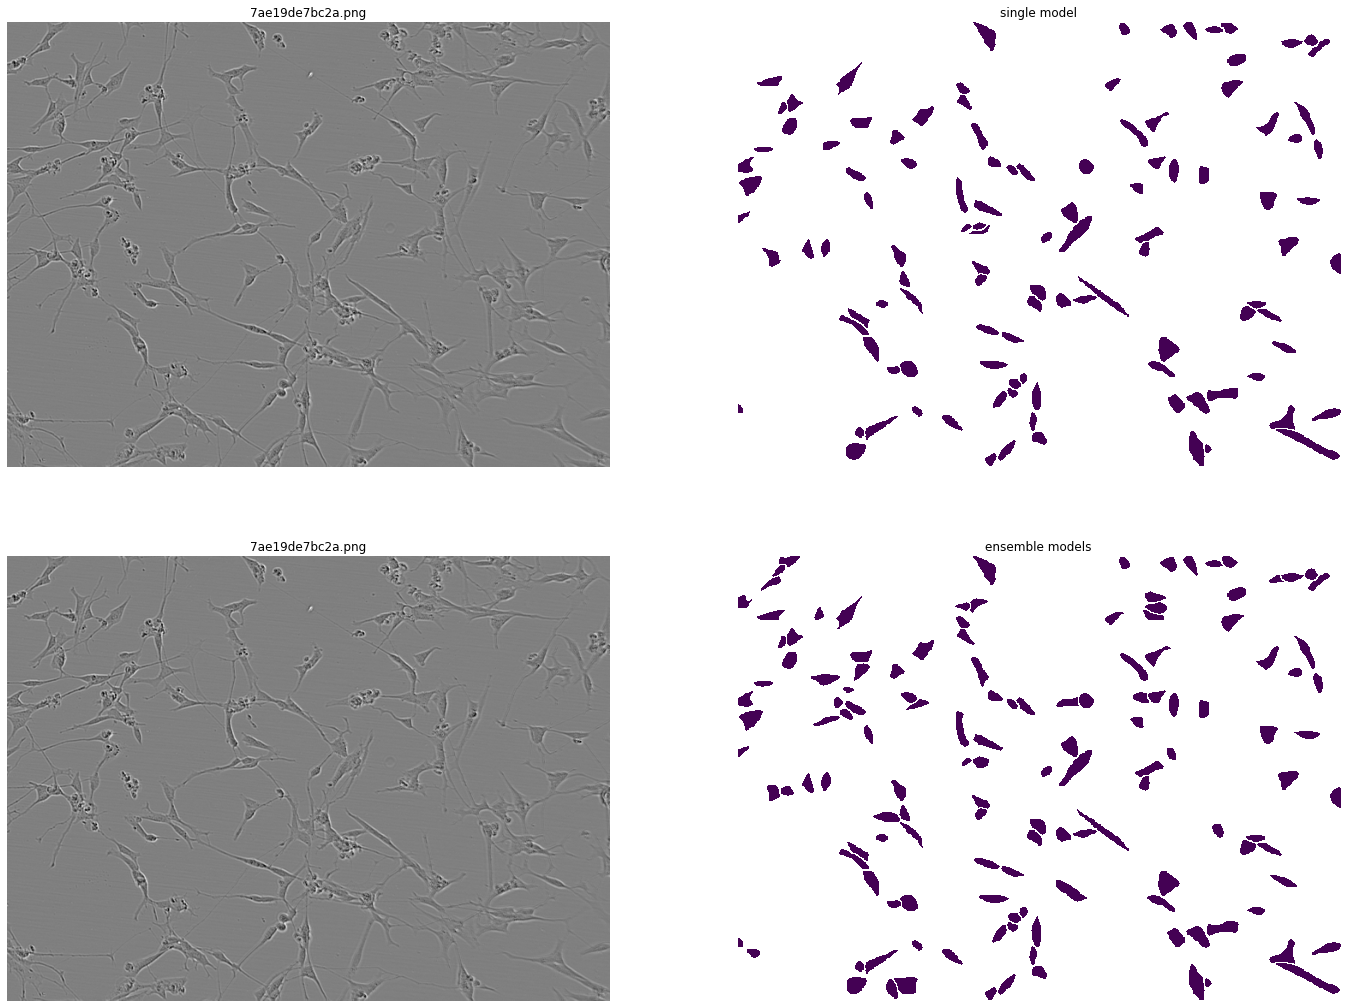

In [154]:
check_nms(model_num=1, ID_TEST=0)

In [150]:
check_nms(model_num=1, ID_TEST=1)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 2 has 2 dimension(s)

In [151]:
check_nms(model_num=1, ID_TEST=2)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

## Inference

In [ ]:
subm_ids, subm_masks = [], []
for test_name in tqdm(test_names):
    if SINGLE_MODE:
        encoded_masks = get_masks(
            test_name, 
            path=SUBM_PATH, 
            model=MODELS[0],
            ths=THSS[0],
            min_pixels=MIN_PIXELS
        )
    else:
        classes, scores, bboxes, masks = ensemble_preds(
            file_name=test_name, 
            path=SUBM_PATH, 
            models=MODELS, 
            ths=THSS
        )
        if NMS:
            classes, scores, masks = nms_predictions(
                classes, 
                scores, 
                bboxes, 
                masks, 
                iou_th=IOU_TH
            )
        elif WBF:
            classes, scores, masks = wbf_predictions(
                classes, 
                scores, 
                bboxes,
                masks,
                len(MODELS),
                iou_th=IOU_TH
            )
        encoded_masks = ensemble_get_masks(
            masks, 
            classes, 
            pxls=MIN_PIXELS
        )
    for enc_mask in encoded_masks:
        subm_ids.append(test_name[:test_name.find('.')])
        subm_masks.append(enc_mask)

In [ ]:
pd.DataFrame({
    'id': subm_ids, 
    'predicted': subm_masks
}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

# References
1. https://www.kaggle.com/vgarshin/detectron2-inference-with-ensemble-and-nms